In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import utils
from Sampling import Sampling
from VAE import VAE
from CAN import CAN

In [8]:
vae_epoch = 10000
can_epoch = 10000
batch_size = 64
latent_dim = 10
beta_eeg = 5.0

In [9]:
data_root = "/home/zainkhan/bci-representation-learning"
eeg_train, eeg_test, pupil_train, pupil_test = utils.read_single_trial_datasets(data_root)

In [10]:
# Load all encoders/decoders
vae = VAE(beta=beta_eeg, latent_dim=latent_dim)
vae.encoder = keras.models.load_model("vae_encoder_z/vae_encoder")
vae.decoder = keras.models.load_model("vae_decoder_z/vae_decoder")

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)    
plt.rc('ytick', labelsize=MEDIUM_SIZE)    
plt.rc('legend', fontsize=MEDIUM_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 8]

In [21]:
def image_split(orig, rec):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)
    
    orig_targ = orig[:len(orig)//2]
    rec_targ = rec[:len(rec)//2]
    orig_dist = orig[len(orig)//2:]
    rec_dist = rec[len(rec)//2:]
    
    return (orig_targ, orig_dist, rec_targ, rec_dist)

In [22]:
def plot_eeg_reconstruction(orig, rec, save=False, filename=''):
    plt.rcParams['figure.figsize'] = [12, 10]
    orig_targ, orig_dist, rec_targ, rec_dist = image_split(orig, rec)
    
    mse = lambda x,y : np.mean(np.square(x - y))
    err_t = np.sqrt(mse(orig_targ, rec_targ))
    err_d = np.sqrt(mse(orig_dist, rec_dist))
    corr_t = pearsonr(orig_targ, rec_targ)[0]
    corr_d = pearsonr(orig_dist, rec_dist)[0]
    
    x = np.linspace(-500, 1000, num=orig.shape[1]//2)
    plt.subplot(2, 1, 1)
    plt.plot(x, orig_targ, label='Original')
    plt.plot(x, rec_targ, label='Reconstruction')
    plt.plot([], [], ' ', label=f'RMSE: {err_t:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_t:.2f}')
    plt.legend(loc='upper left', frameon=True)
    plt.title('Channel Averaged Original vs Reconstruction', fontsize=16)
    plt.ylabel('Targets (Avg Z)')

    plt.subplot(2, 1, 2)
    plt.plot(x, orig_dist, label='Original')
    plt.plot(x, rec_dist, label='Reconstruction')  
    plt.plot([], [], ' ', label=f'RMSE: {err_d:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_d:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Distractors (Avg Z)')
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if save:
        fig.savefig(filename + '.png')

In [23]:
_, _, eeg_encode = vae.encoder.predict(eeg_test)
ee_rec = vae.decoder.predict(eeg_encode)

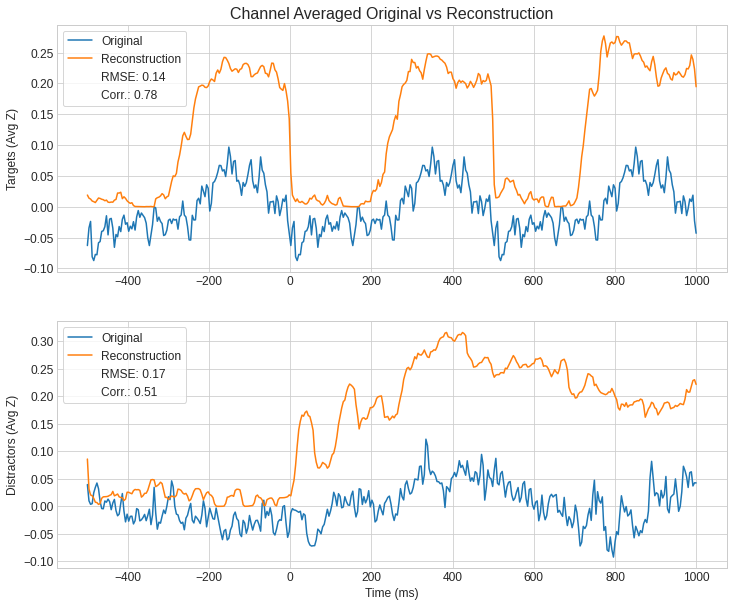

In [24]:
i = 500
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec[i], save=True, filename=fn)

In [25]:
_, _, eeg_encode_train = vae.encoder.predict(eeg_train)
ee_rec_train = vae.decoder.predict(eeg_encode_train)

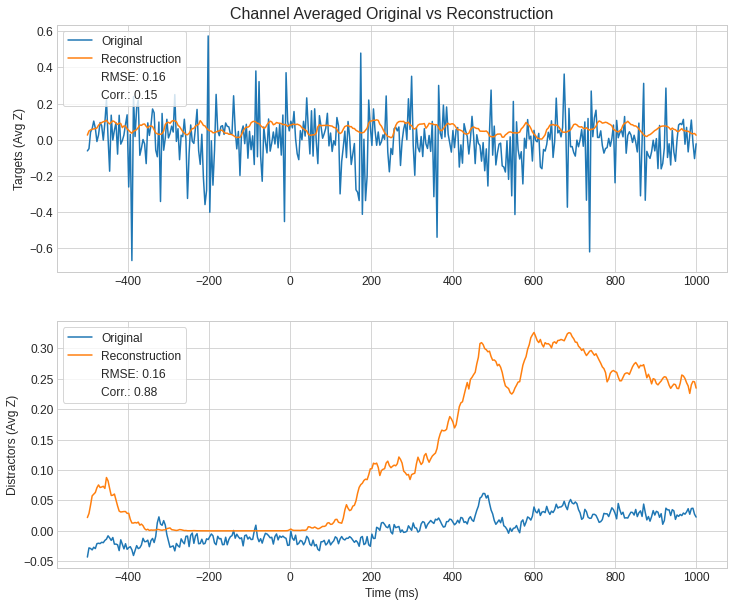

In [26]:
i = 70
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_train[i], ee_rec_train[i], save=False, filename=fn)

In [27]:
def plot_subj_cond(X, vals, ylabel, legend, filename='', width=0.8):
    plt.rcParams['figure.figsize'] = [15, 8]
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align='edge', label=legend[i])   
    plt.xticks(_X, X)
    plt.xlabel('Subject (#)')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if filename != '':
        fig.savefig(filename + '.png')

In [41]:
eeg_free, eeg_eye, pupil_free, pupil_eye = utils.read_dataset_by_condition(data_root)

eeg_free_rec = []
eeg_eye_rec = []
for i in range(len(eeg_free)):
    _, _, encoded = vae.encoder.predict(eeg_free[i])
    eeg_free_rec.append(vae.decoder.predict(encoded))
    
    _, _, encoded = vae.encoder.predict(eeg_eye[i])
    eeg_eye_rec.append(vae.decoder.predict(encoded))

In [65]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
for i in range(len(eeg_free)):
    eeg_free[i] = simplify(eeg_free[i])
    eeg_eye[i] = simplify(eeg_eye[i])
    eeg_free_rec[i] = simplify(eeg_free_rec[i])
    eeg_eye_rec[i] = simplify(eeg_eye_rec[i])

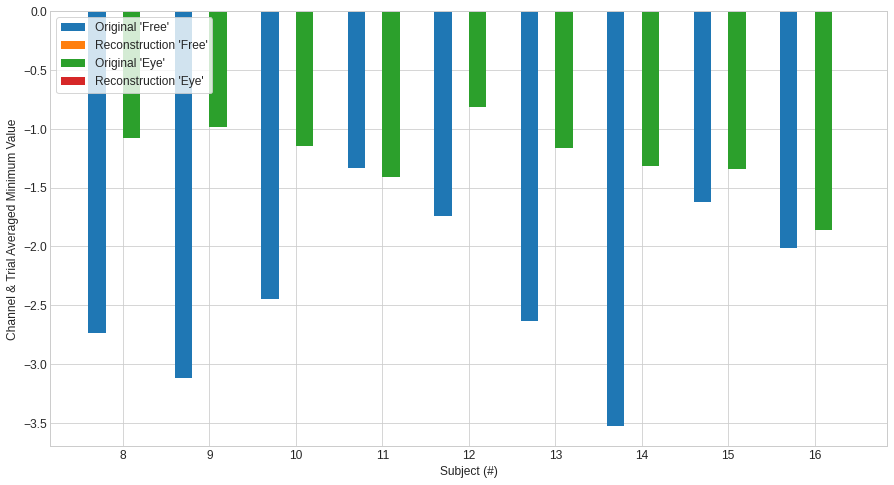

In [30]:
f = lambda x: np.min(x)
ef = [f(i) for i in eeg_free]
efr = [f(i) for i in eeg_free_rec]
ee = [f(i) for i in eeg_eye]
eer = [f(i) for i in eeg_eye_rec]

legend = ['Original \'Free\'', 'Reconstruction \'Free\'', 'Original \'Eye\'', 'Reconstruction \'Eye\'']
ylabel = 'Channel & Trial Averaged Minimum Value'
filename = 'min'
plot_subj_cond(range(8,17), [ef, efr, ee, eer], ylabel, legend, filename)

In [66]:
eeg_free_targ = [i[:len(i)//2] for i in eeg_free]
eeg_free_dist = [i[len(i)//2:] for i in eeg_free]
eeg_eye_targ = [i[:len(i)//2] for i in eeg_eye]
eeg_eye_dist = [i[len(i)//2:] for i in eeg_eye]

eeg_free_rec_targ = [i[:len(i)//2] for i in eeg_free_rec]
eeg_free_rec_dist = [i[len(i)//2:] for i in eeg_free_rec]
eeg_eye_rec_targ = [i[:len(i)//2] for i in eeg_eye_rec]
eeg_eye_rec_dist = [i[len(i)//2:] for i in eeg_eye_rec]

In [67]:
eeg_free[0].shape
eeg_free_targ[0].shape

(32, 768)

In [68]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
for i in range(len(eeg_free_targ)):
    eeg_free_targ[i] = simplify(eeg_free_targ[i])
    eeg_free_dist[i] = simplify(eeg_free_dist[i])
    eeg_eye_targ[i] = simplify(eeg_eye_targ[i])
    eeg_eye_dist[i] = simplify(eeg_eye_dist[i])
    
    eeg_free_rec_targ[i] = simplify(eeg_free_rec_targ[i])
    eeg_free_rec_dist[i] = simplify(eeg_free_rec_dist[i])
    eeg_eye_rec_targ[i] = simplify(eeg_eye_rec_targ[i])
    eeg_eye_rec_dist[i] = simplify(eeg_eye_rec_dist[i])

In [69]:
eeg_free_targ[0].shape

(768,)

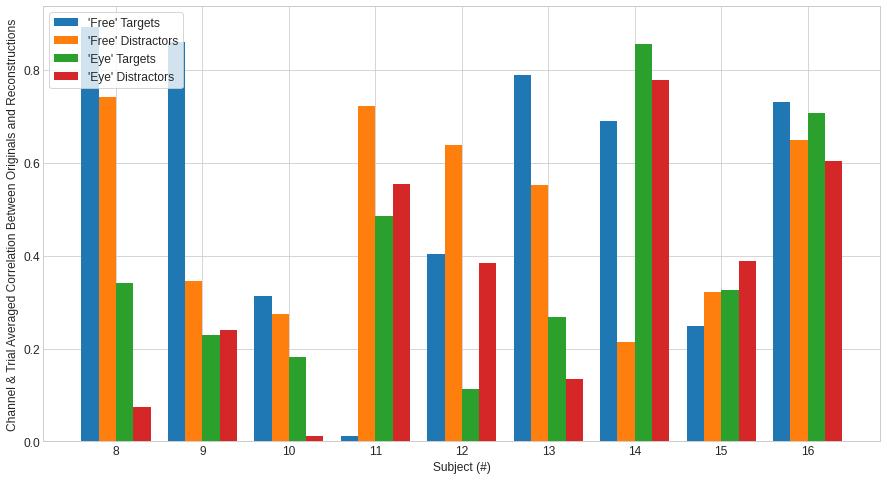

In [70]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
eft = [g(eeg_free_targ[i], eeg_free_rec_targ[i]) for i in range(len(eeg_free_targ))]
efd = [g(eeg_free_dist[i], eeg_free_rec_dist[i]) for i in range(len(eeg_free_dist))]
eet = [g(eeg_eye_targ[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_targ))]
eed = [g(eeg_eye_dist[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_dist))]

legend = ['\'Free\' Targets', '\'Free\' Distractors', '\'Eye\' Targets', '\'Eye\' Distractors']
ylabel = 'Channel & Trial Averaged Correlation Between Originals and Reconstructions'
filename = 'correl'
plot_subj_cond(range(8,17), [eft, efd, eet, eed], ylabel, legend, filename)

In [118]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=50, init='pca', random_state=0)
X_tsne = tsne.fit_transform(eeg_encode)
y = range(len(eeg_encode))

def plot_embedding(X, colormetric, title=None, filename=None):
    plt.rcParams['figure.figsize'] = [12, 10]
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(colormetric[i]))
    if title is not None:
        plt.title(title)
    plt.colorbar()
    fig = plt.gcf()
    plt.show()
    if filename is not None:
        fig.savefig(filename + '.png')

In [81]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
eeg_test_red = []
ee_rec_red = []
for i in range(len(eeg_test)):
    eeg_test_red.append(simplify(eeg_test[i]))
    ee_rec_red.append(simplify(ee_rec[i]))

(768,)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

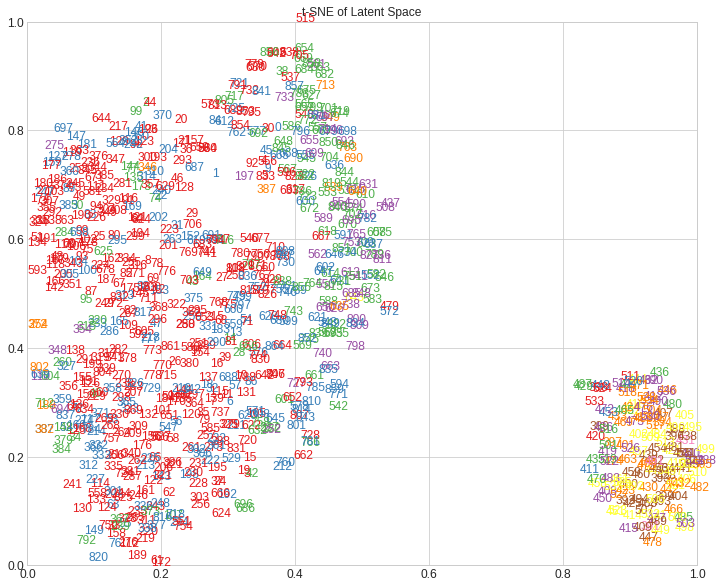

In [119]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
corr = [g(eeg_test_red[i], ee_rec_red[i]) for i in range(len(eeg_test))]
plot_embedding(X_tsne, corr, 't-SNE of Latent Space', 'tsne')

In [110]:
print(corr[740])

0.3687862965632363


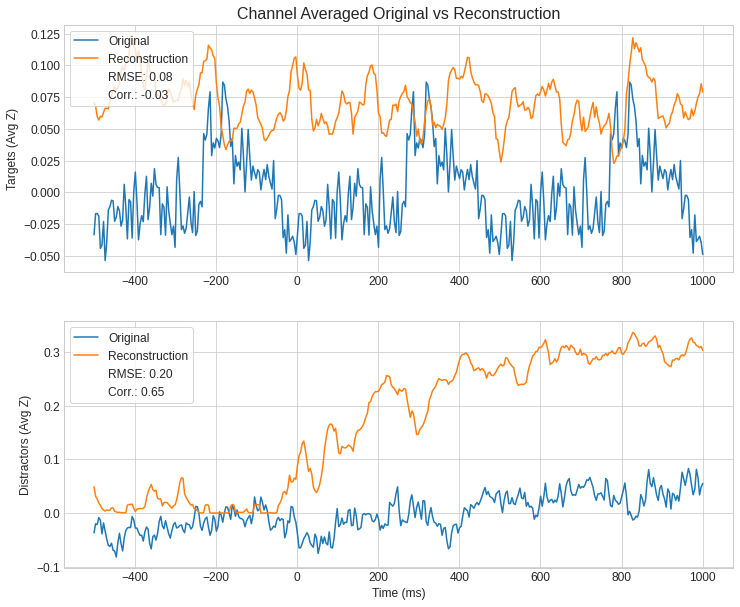

In [111]:
i = 508
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec[i], save=False, filename=fn)

In [80]:
eeg_test.shape

(865, 64, 768, 1)